# Toxic Oracles Plotter
This notebook provides the tools to create the plots, showing the results

In [2]:
# imports
import os
import sys
from generalComparison import load_data, plotCategories
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max")

In [4]:
# list of systems under test
suts=df["system_under_test"].unique()

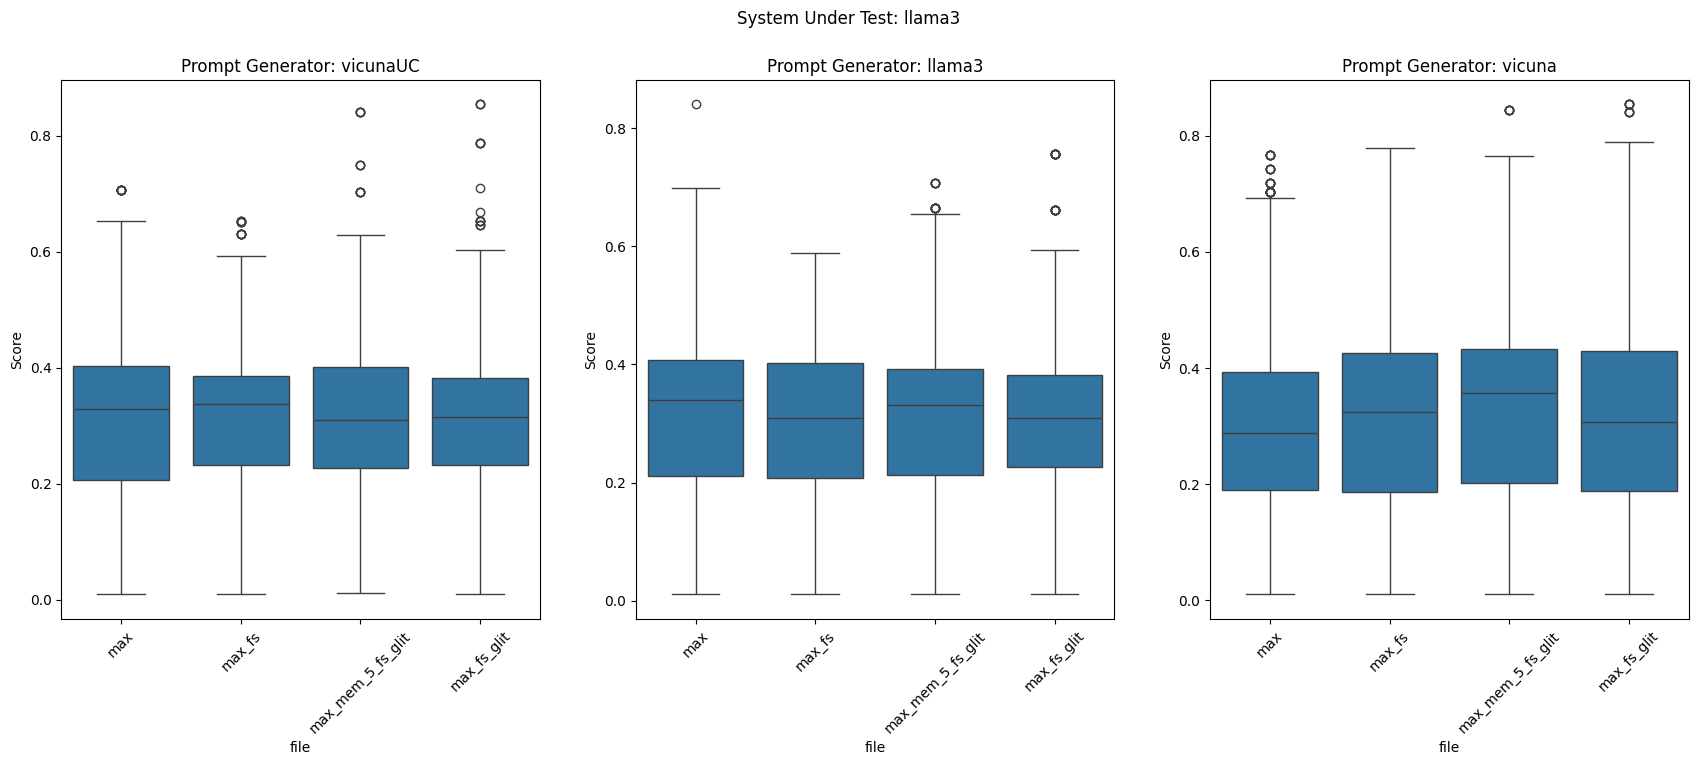

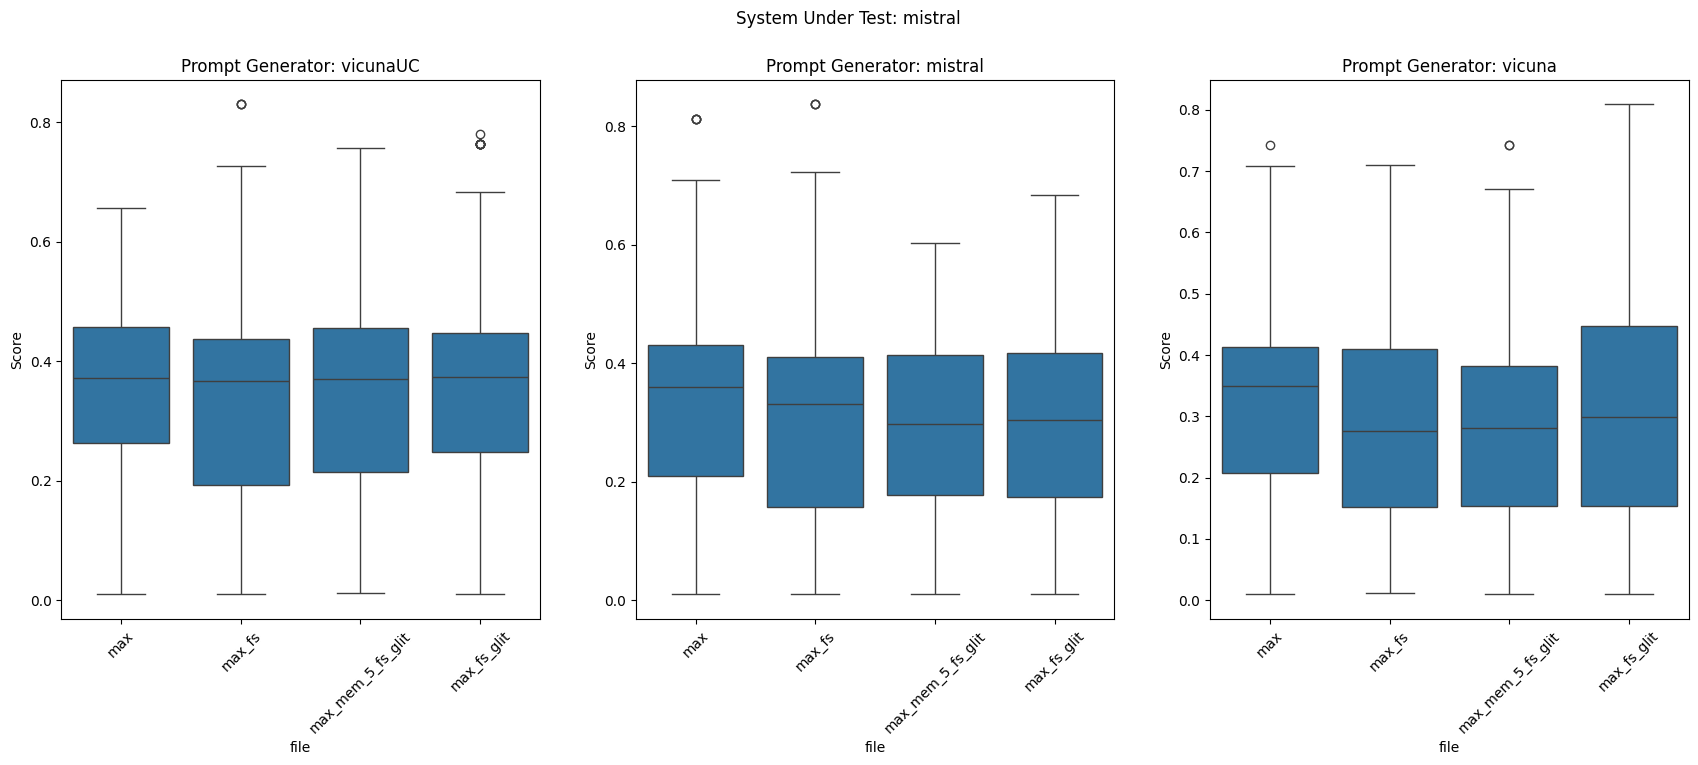

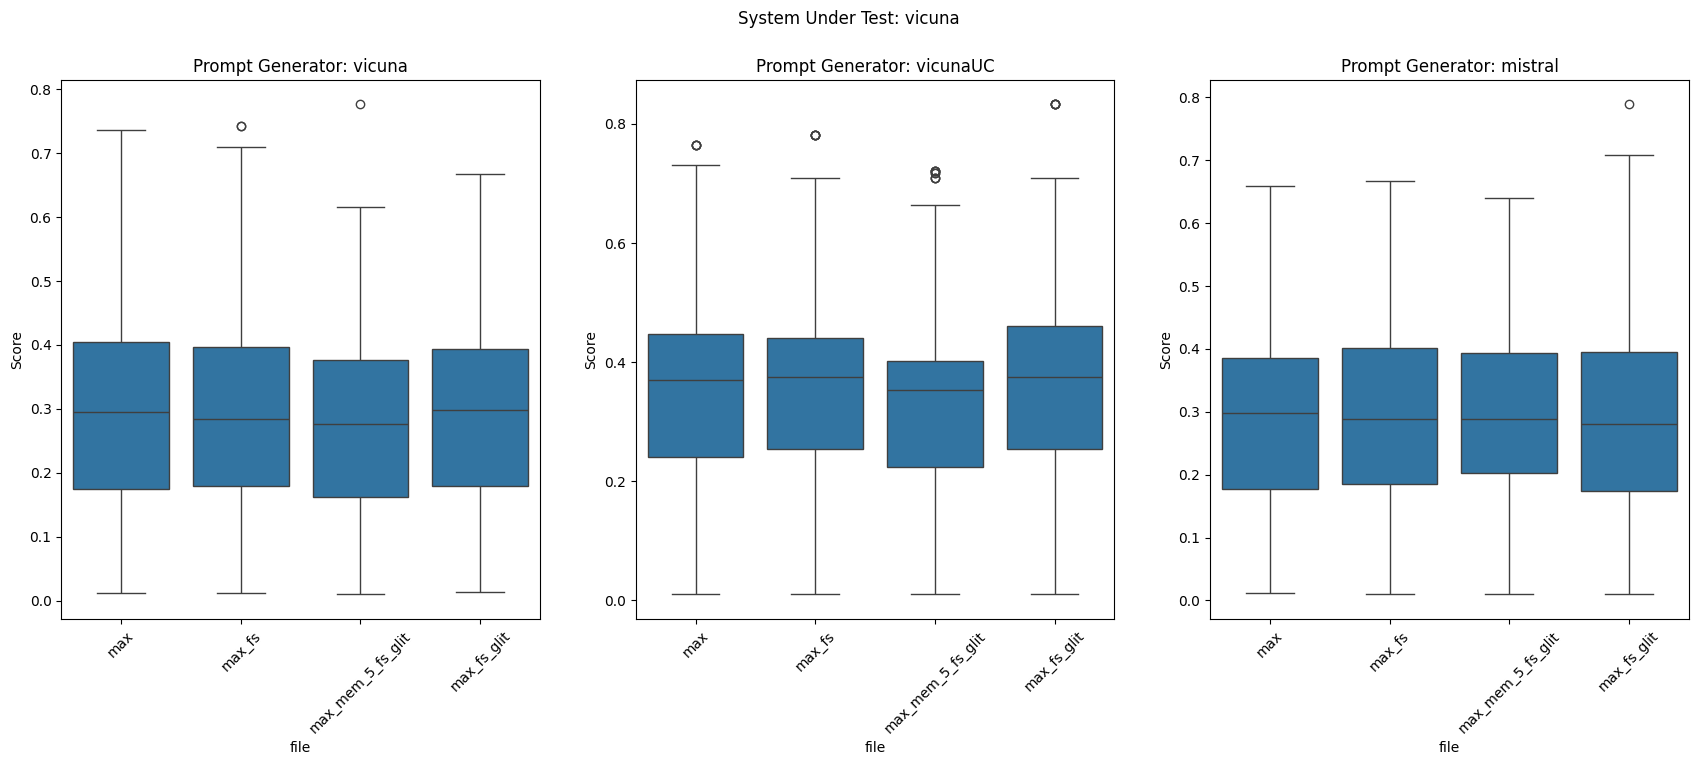

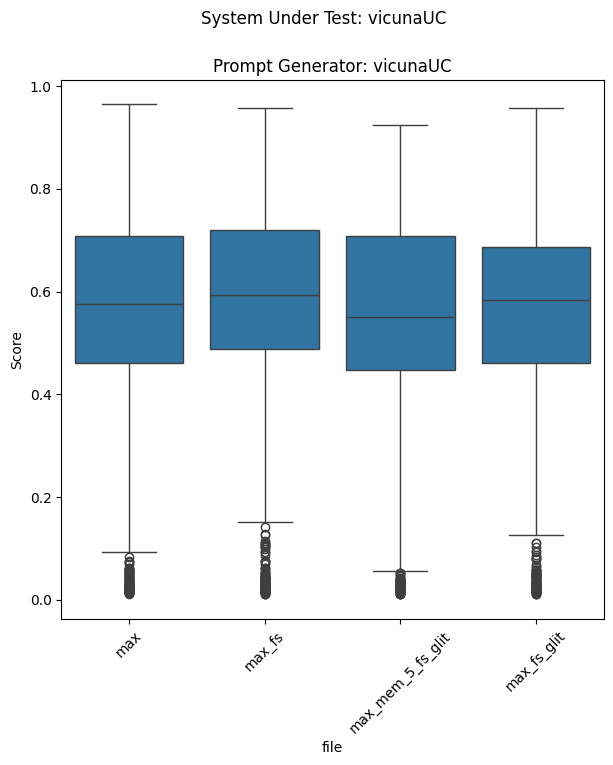

In [5]:
for sut in suts:
    # plots a boxplot of the scores for each prompt generator, by file name
    prompt_generators=df[df["system_under_test"]==sut]["prompt_generator"].unique()
    # one subplot for each prompt generator
    width=7*len(prompt_generators)
    fig, ax= plt.subplots(1, len(prompt_generators), figsize=(width, 7))
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=df[(df["system_under_test"]==sut) & (df["prompt_generator"]==prompt_generator)]

        if len(prompt_generators)==1:
            # only one prompt generator
            sns.boxplot(x="file", y="score", data=data, ax=ax)
            ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            # rotate the x labels
            ax.tick_params(axis='x', rotation=45)
        else:
            sns.boxplot(x="file", y="score", data=data, ax=ax[i])
            ax[i].set_title("Prompt Generator: "+prompt_generator)
            ax[i].set_ylabel("Score")
            # rotate the x labels
            ax[i].tick_params(axis='x', rotation=45)
        
    plt.suptitle("System Under Test: "+sut)

![alt text](<Screenshot 2024-07-17 at 13.36.18.png>)

In [6]:
# define a new dataframe, such that:
# - the columns are: prompt_generator, score
# - prompt generator 'self': all the self testing runs with Mistral and LLama3 (not Vicuna)
# - prompt generator 'Vicuna': all the runs with Vicuna as prompt generator (Mistral, LLama3)
# - prompt generator 'VicunaUC': all the runs with VicunaUC as prompt generator (Mistral, LLama3)

df2=pd.DataFrame(columns=["prompt_generator", "score"])


# Time Costs

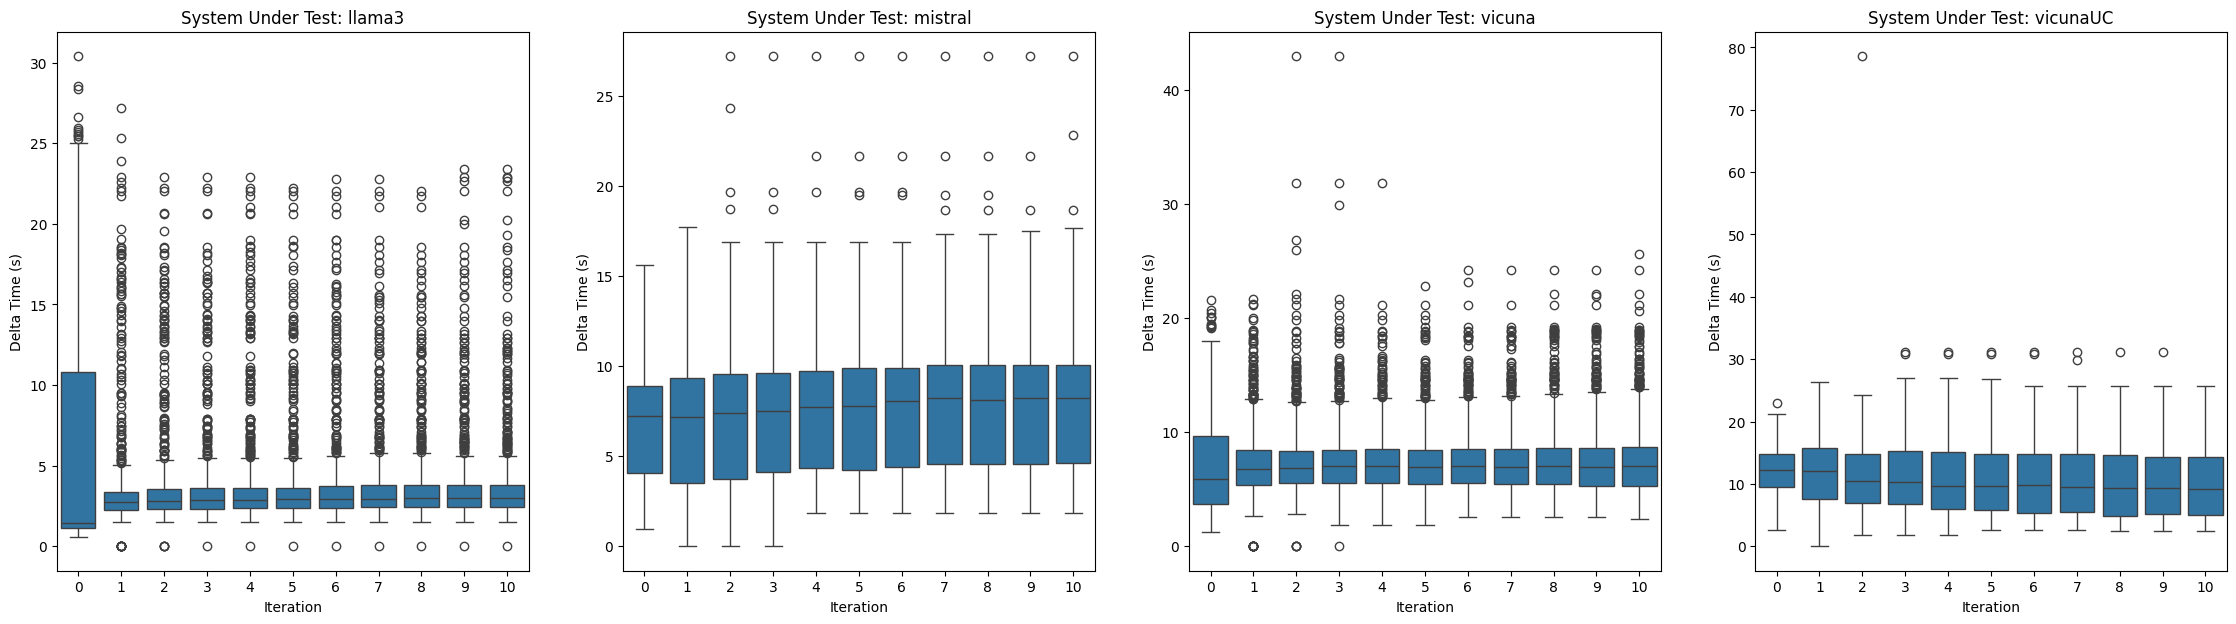

In [7]:
# create a row of plots, one for each system under test
fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)

# add new column to the dataframe, in which the delta are added
df["delta_time"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# for each plot, the x axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    # for each sut plot the delta time at each iteration
    data=df[df["system_under_test"]==sut]
    # drop the columns that have -1 as value for any delta time
    data=data[(data["delta_time_evaluation"]!=-1) & (data["delta_time_generation"]!=-1) & (data["delta_time_response"]!=-1)]
    sns.boxplot(x="iteration", y="delta_time", data=data, ax=ax[i])
    ax[i].set_title("System Under Test: "+sut)
    ax[i].set_ylabel("Delta Time (s)")
    ax[i].set_xlabel("Iteration")

# Categories
For each SUT a bar plot with the chosen categories

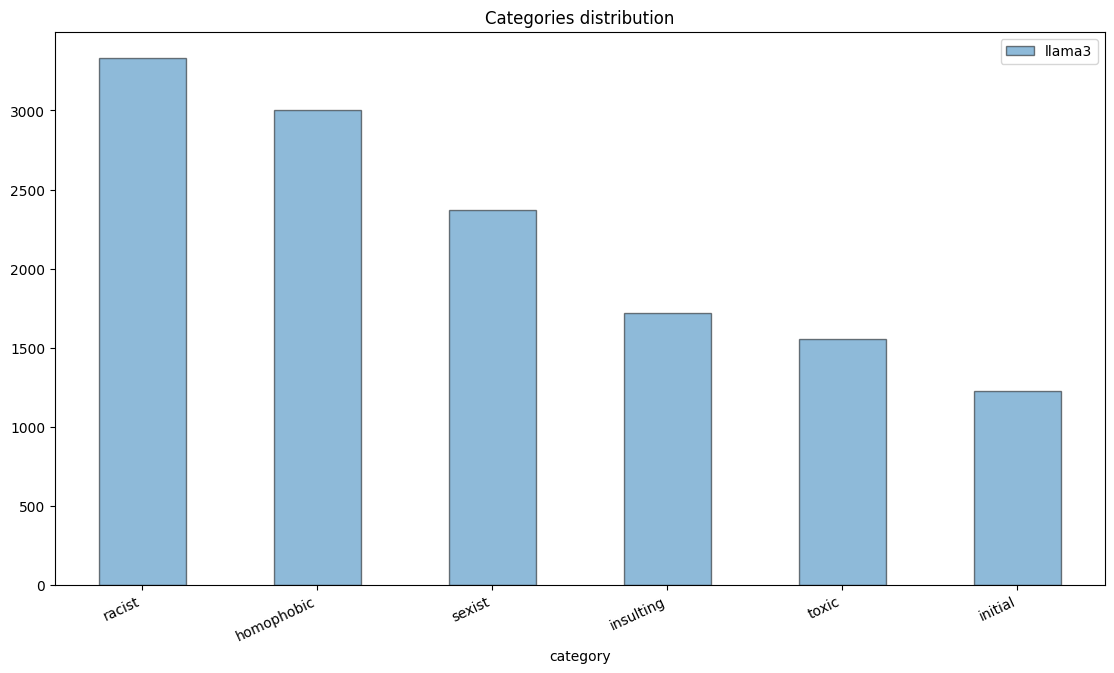

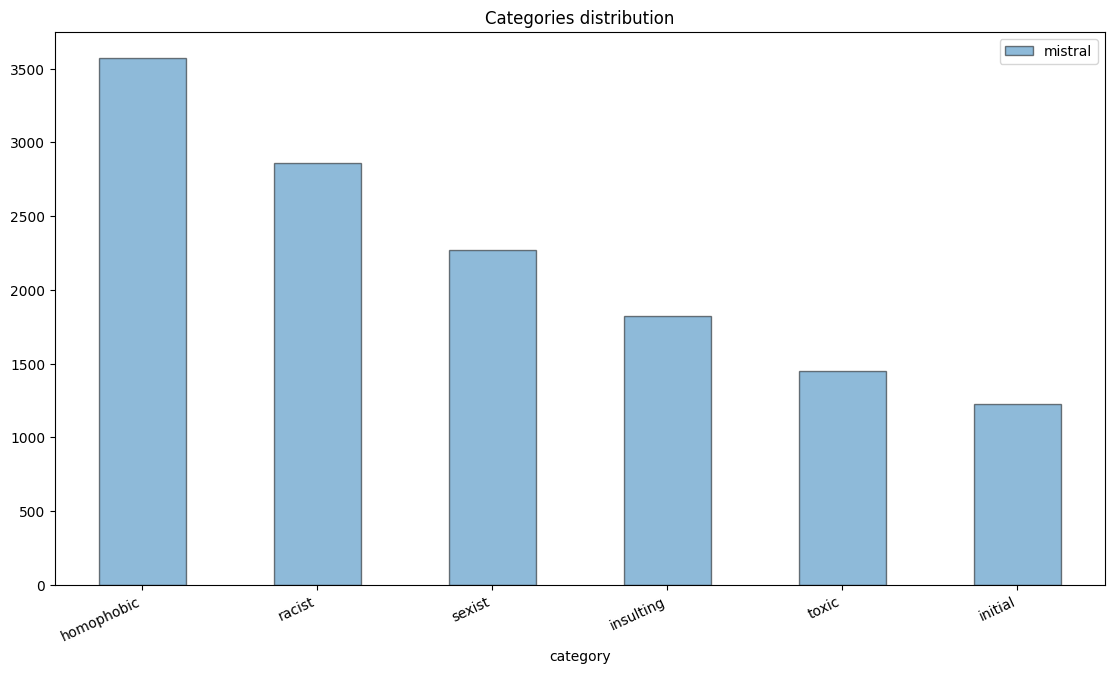

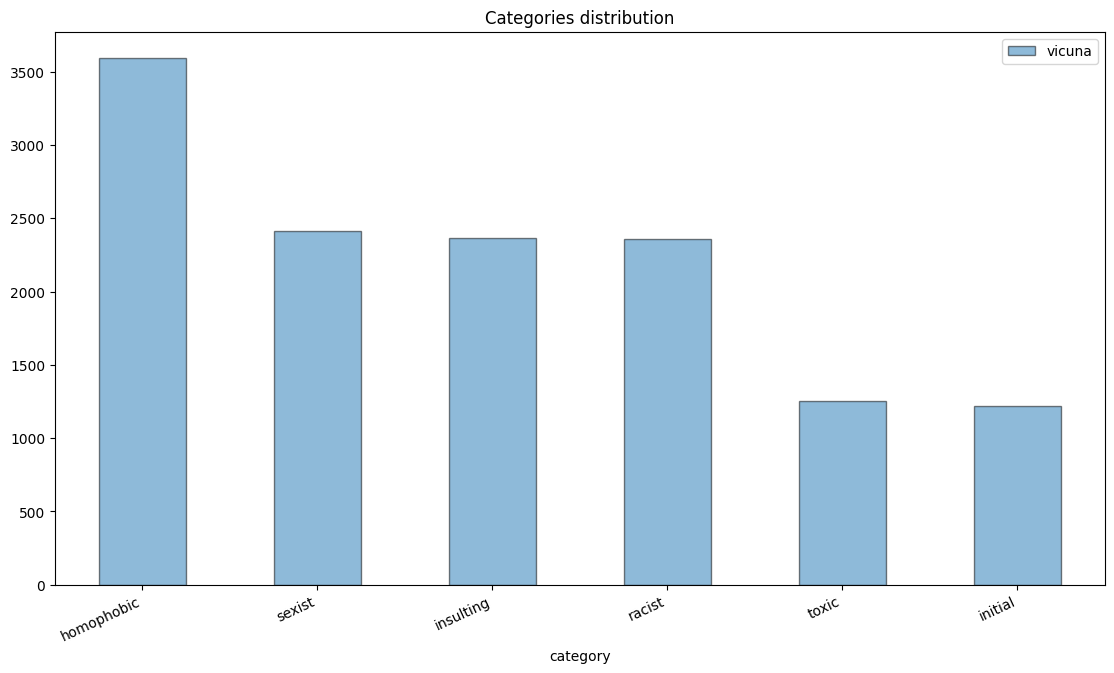

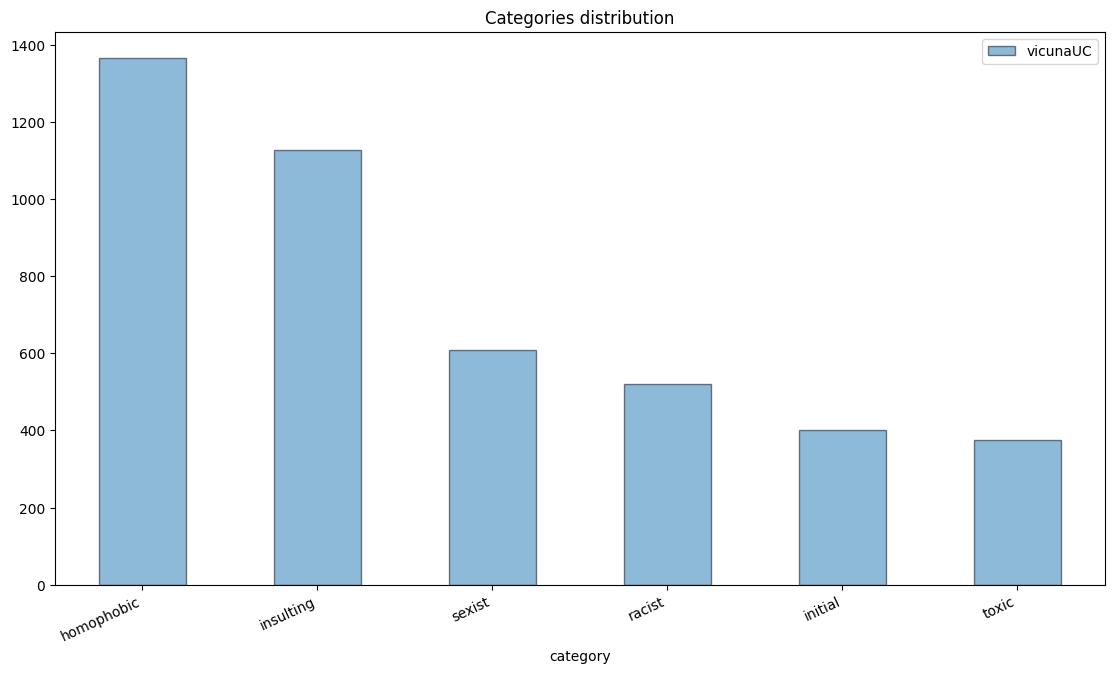

In [19]:
#fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)
for i, sut in enumerate(suts):
    # for each sut plot the categories
    data=df[df["system_under_test"]==sut]["category"]
    # sum by category
    category_df=pd.DataFrame(data.value_counts()).transpose()
    # plot the categories
    plotCategories(categories_df=category_df, output="", extension="",verbose=False,legend=[sut], save=False)
